#### RGR Modelling and Analysis

As part of this notebook, I run a general analysis, a propensity model, and a simple hierarchical model for clustering. This notebook suppors findings found in the 'Deliveroo RGR' slide deck.

##### Notebook overview:

1. Setup
2. General exploration and EDA
3. Propensity model
4. Hierarchical clustering


#### 1. Setup

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.cluster import AgglomerativeClustering
from sklearn import preprocessing
import scipy.cluster.hierarchy as sch
import lightgbm as lgb
from hyperopt import hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from hyperopt.fmin import fmin
from hyperopt.pyll import scope

from google.cloud import storage
from google.cloud import bigquery

In [127]:
# user-defined inputs
PROJECT_ID='deliveroo-301715'
BUCKET_NAME='deliveroo-rgr'
DATA = 'rgr_data_test.csv'

# dependent variables
storage_client = storage.Client(PROJECT_ID)
bucket_path = 'gs://' + BUCKET_NAME
client = bigquery.Client()

In [ ]:
# import data
data = pd.read_csv(bucket_path+'/'+DATA)

#### 2. General exploration and EDA

In [129]:
data.head()

RIDER_ID        LOCATION               APPLICATION_DATE      APPLICATION_APPROVED_DATE FIRST_WORK_DATE ACQUISITION_CHANNEL VEHICLE_TYPE  DAYS_SINCE_ACQUISITION  HOURS_WORKED_CUMULATIVE  ORDERS_DELIVERED_CUMULATIVE  THROUGHPUT_CUMULATIVE  REFERRALS_CUMULATIVE  SUCCESSFUL_REFERRALS_CUMULATIVE
0     73350  Roo de Janeiro  2016-10-29 00:00:00.000000000  2016-11-07 00:00:00.000000000      2016-11-09             Organic      Bicycle                       7                     11.9                           12                   1.01                   NaN                              NaN
1     73350  Roo de Janeiro  2016-10-29 00:00:00.000000000  2016-11-07 00:00:00.000000000      2016-11-09             Organic      Bicycle                      14                     13.1                           13                   0.99                   NaN                              NaN
2     73350  Roo de Janeiro  2016-10-29 00:00:00.000000000  2016-11-07 00:00:00.000000000      2016-11-09             Organic      Bicycle                      28                     19.1                           20                   1.04                   NaN                              NaN
3     73350  Roo de Janeiro  2016-10-29 00:00:00.000000000  2016-11-07 00:00:00.000000000      2016-11-09             Organic      Bicycle                      56                     33.4                           39                   1.17                   NaN                              NaN
4     73350  Roo de Janeiro  2016-10-29 00:00:00.000000000  2016-11-07 00:00:00.000000000      2016-11-09             Organic      Bicycle                      84                     33.4                           39                   1.17                   NaN                              NaN

In [131]:
# check for duplicate rider ids
data['DAYS_SINCE_ACQUISITION'].value_counts()

84     5173
7      5173
56     5173
168    5173
28     5173
14     5173
Name: DAYS_SINCE_ACQUISITION, dtype: int64

In [ ]:
# creating this for later - creating a variable without duplicates at max date avaiable.
data_max = data[data['DAYS_SINCE_ACQUISITION']==168]

In [132]:
# Data types - no change needed
data.dtypes

RIDER_ID                             int64
LOCATION                            object
APPLICATION_DATE                    object
APPLICATION_APPROVED_DATE           object
FIRST_WORK_DATE                     object
                                    ...   
HOURS_WORKED_CUMULATIVE            float64
ORDERS_DELIVERED_CUMULATIVE          int64
THROUGHPUT_CUMULATIVE              float64
REFERRALS_CUMULATIVE               float64
SUCCESSFUL_REFERRALS_CUMULATIVE    float64
Length: 13, dtype: object

In [133]:
# Some summary stats - some notable outliers
data.describe()

RIDER_ID  DAYS_SINCE_ACQUISITION  HOURS_WORKED_CUMULATIVE  ORDERS_DELIVERED_CUMULATIVE  THROUGHPUT_CUMULATIVE  REFERRALS_CUMULATIVE  SUCCESSFUL_REFERRALS_CUMULATIVE
count   31038.000000            31038.000000             31038.000000                 31038.000000           31038.000000           4056.000000                      4056.000000
mean    80934.348347               59.500000                88.131536                   180.793608               1.874058              2.025148                         0.376726
std     12777.801095               55.081888               144.440770                   329.754352               0.704813              5.167179                         0.778940
min      1864.000000                7.000000                 0.200000                     0.000000               0.000000              1.000000                         0.000000
25%     70990.000000               14.000000                15.700000                    26.000000               1.460000              1.000000                         0.000000
50%     77741.000000               42.000000                37.100000                    67.000000               1.940000              1.000000                         0.000000
75%     94220.000000               84.000000                94.300000                   180.000000               2.350000              2.000000                         1.000000
max    103776.000000              168.000000              2042.400000                  4856.000000               6.150000            286.000000                        27.000000

In [134]:
# unique number of riders
unique_num_riders = data.RIDER_ID.nunique()
unique_num_riders

5173

In [135]:
# unique locations
data.LOCATION.unique()

# total number of riders in each location
data[['RIDER_ID']].groupby(data['LOCATION']).agg(['count', 'size', 'nunique'])

RIDER_ID               
                  count   size nunique
LOCATION                              
Roo Town           1944   1944     324
Roo York          20214  20214    3369
Roo de Janeiro     8880   8880    1480

In [136]:
# acquisition channel - about 1/4 were referred
data[['RIDER_ID']].groupby(data['ACQUISITION_CHANNEL']).agg(['count', 'size', 'nunique'])

RIDER_ID               
                       count   size nunique
ACQUISITION_CHANNEL                        
Digital                 4506   4506     751
Job Platforms            402    402      67
Offline                 1776   1776     296
Organic                16410  16410    2735
Referral                7296   7296    1216
Unknown                  648    648     108

In [137]:
# vehicle type
data[['RIDER_ID']].groupby(data['VEHICLE_TYPE']).agg(['count', 'size', 'nunique'])

RIDER_ID               
                        count   size nunique
VEHICLE_TYPE                                
Bicycle                 24180  24180    4030
Electric Bicycle           18     18       3
Motor Vehicle             288    288      48
Pedestrian / Walker        54     54       9
Scooter / Motorcycle     6498   6498    1083

In [138]:
print("Min first work date:", data.FIRST_WORK_DATE.min(), "|", "Max first work date:", data.FIRST_WORK_DATE.max())

Min first work date: 2016-10-13 | Max first work date: 2017-04-08


Let's get some naive answers about the stats we have:

1. On average, do referred riders are riders that are referred do they provide more value?
To understand if riders that are referred provide more value, we're going to look at two descriptors of value, one - do they have higher numbers of worked hours+deliveries | do they have higher throughput. Naively, not necessarily - but worth exploring more.
2. What percent of riders refer? What percent of riders successfully refer?
Just to have some more stats to play with.
3. What percent of riders who are referred go on to refer?
It would be interesting to see if those riders that are referred bring in more referrals

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='HOURS_WORKED_CUMULATIVE', ylabel='ORDERS_DELIVERED_CUMULATIVE'>

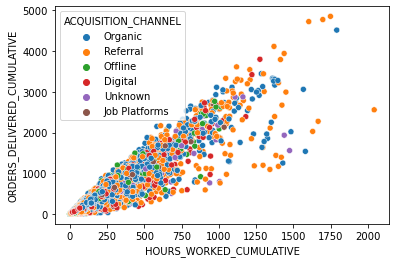

In [139]:
# no clear broad visual grouping
sns.scatterplot('HOURS_WORKED_CUMULATIVE', 'ORDERS_DELIVERED_CUMULATIVE', hue='ACQUISITION_CHANNEL', data=data)

<AxesSubplot:xlabel='ACQUISITION_CHANNEL', ylabel='THROUGHPUT_CUMULATIVE'>

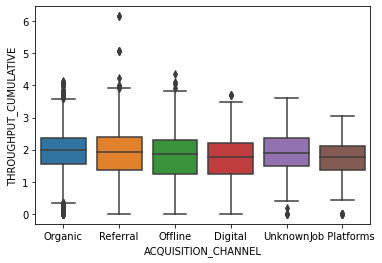

In [140]:
# do referred users have higher throughput on average? Not really
sns.boxplot(x = 'ACQUISITION_CHANNEL', y='THROUGHPUT_CUMULATIVE', data=data)

In [141]:
# what percent of riders refer? 35.8%
data[['RIDER_ID']].groupby(data['REFERRALS_CUMULATIVE']).agg(['nunique']).sum() / unique_num_riders

# what percent of riders that are referred go on to refer?
data[['RIDER_ID']].groupby(data['SUCCESSFUL_REFERRALS_CUMULATIVE']).agg(['nunique'])
# SUCCESSFUL_REFERRALS_CUMULATIVE

RIDER_ID
                                 nunique
SUCCESSFUL_REFERRALS_CUMULATIVE         
0.0                                 1037
1.0                                  450
2.0                                   92
3.0                                   24
4.0                                   11
5.0                                    4
6.0                                    2
7.0                                    1
27.0                                   1

In [142]:
# extracting subset of riders that are referred, that have referred, and that have successfully referred
riders_refer = """
SELECT 
    DISTINCT RIDER_ID,
    CASE 
      WHEN ACQUISITION_CHANNEL = 'Referral' THEN 1
      ELSE 0
    END AS IS_REFERRED,
    CASE 
      WHEN SUM(REFERRALS_CUMULATIVE) > 0 THEN 1
      ELSE 0
    END AS HAS_REFERRED,
    CASE
      WHEN SUM(SUCCESSFUL_REFERRALS_CUMULATIVE) > 0 THEN 1
      ELSE 0
    END AS REFERRED_SUCCESSFULLY
FROM `deliveroo-301715.rgr_data.data` 
GROUP BY 1,2

"""

In [143]:
# creating a dataframe from above query
riders_refer_df = client.query(riders_refer).to_dataframe()
riders_refer_df.head()

RIDER_ID  IS_REFERRED  HAS_REFERRED  REFERRED_SUCCESSFULLY
0     80128            0             0                      0
1     83411            1             0                      0
2     83434            0             0                      0
3     83345            0             0                      0
4     83205            0             0                      0

In [144]:
# understandng the total number of riders that have referred
riders_have_referred = riders_refer_df.loc[riders_refer_df['HAS_REFERRED'] == 1, 'RIDER_ID'].nunique()
# 1272 riders have referred
riders_have_referred

1272

In [145]:
# Successful number of riders: I'm assuming that you can only refer successfully if you've referred
riders_referred_success = riders_refer_df.loc[riders_refer_df['REFERRED_SUCCESSFULLY'] == 1, 'RIDER_ID'].nunique()
riders_referred_success

512

In [146]:
print("Of the", riders_have_referred / unique_num_riders, " % of riders that have referred", (riders_referred_success / riders_have_referred * 100), "% have successfully referred")


Of the 0.2458921322250145  % of riders that have referred 40.25157232704403 % have successfully referred


In [147]:
# number of riders that were referred
num_riders_referred = riders_refer_df.loc[riders_refer_df['IS_REFERRED'] == 1, 'RIDER_ID'].nunique()
# num_riders_referred / unique_num_riders = 0.23506669244152328

# Of the 1216 riders that were referred, 452 went on to refer or 37.2%: 19.4% more likely than organic to refer
riders_refer_df.RIDER_ID[(riders_refer_df.IS_REFERRED == 1) & (riders_refer_df.HAS_REFERRED == 1)].nunique()

452

In [148]:
# of the riders that came on organically, 30% went on to refer
riders_refer_df.RIDER_ID[(riders_refer_df.IS_REFERRED == 0) & (riders_refer_df.HAS_REFERRED == 1)].nunique()

820

In this section I'd like to understand throughput by vehicle type

In [149]:
# what i want is rider_id (unique), vehicle type, throughput
throughput_vehicle = """
SELECT 
    DISTINCT RIDER_ID,
    VEHICLE_TYPE,
    AVG(THROUGHPUT_CUMULATIVE) AS AVERAGE_THROUGHPUT
FROM `deliveroo-301715.rgr_data.data` 
GROUP BY 1,2

"""

throughput_vehicle_df = client.query(throughput_vehicle).to_dataframe()
throughput_vehicle_df.head()

RIDER_ID          VEHICLE_TYPE  AVERAGE_THROUGHPUT
0     80128  Scooter / Motorcycle            1.608333
1     83411               Bicycle            1.720000
2     83434               Bicycle            0.000000
3     83345               Bicycle            0.515000
4     83205               Bicycle            0.000000

(array([1.870e+02, 3.960e+02, 8.450e+02, 1.313e+03, 1.008e+03, 2.470e+02,
        3.100e+01, 2.000e+00, 0.000e+00, 1.000e+00]),
 array([0.   , 0.543, 1.086, 1.629, 2.172, 2.715, 3.258, 3.801, 4.344,
        4.887, 5.43 ]),
 <BarContainer object of 10 artists>)

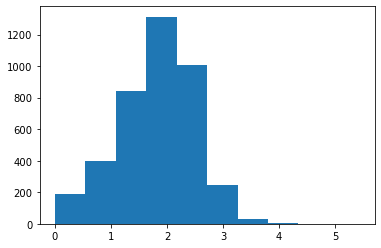

In [151]:
# throughput by bicycle hist
plt.hist(throughput_vehicle_df['AVERAGE_THROUGHPUT'][throughput_vehicle_df['VEHICLE_TYPE'] == 'Bicycle'])

(array([ 14.,  19.,  67., 120., 216., 303., 221.,  92.,  26.,   5.]),
 array([0.        , 0.40066667, 0.80133333, 1.202     , 1.60266667,
        2.00333333, 2.404     , 2.80466667, 3.20533333, 3.606     ,
        4.00666667]),
 <BarContainer object of 10 artists>)

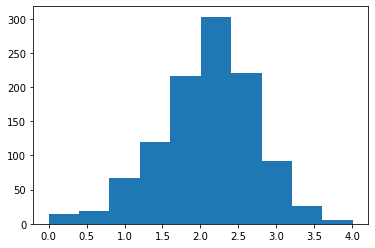

In [152]:
# throughput by scooter/motorcycle hist
plt.hist(throughput_vehicle_df['AVERAGE_THROUGHPUT'][throughput_vehicle_df['VEHICLE_TYPE'] == 'Scooter / Motorcycle'])

(array([3., 2., 7., 8., 8., 8., 5., 3., 2., 2.]),
 array([1.31      , 1.45733333, 1.60466667, 1.752     , 1.89933333,
        2.04666667, 2.194     , 2.34133333, 2.48866667, 2.636     ,
        2.78333333]),
 <BarContainer object of 10 artists>)

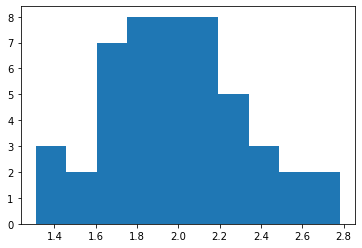

In [153]:
# throughput by motor vehicle hist
plt.hist(throughput_vehicle_df['AVERAGE_THROUGHPUT'][throughput_vehicle_df['VEHICLE_TYPE'] == 'Motor Vehicle'])

#### A little outlier exploration

In [154]:
# at max 168 days, how many have made different numbers of referrals
data_max['REFERRALS_CUMULATIVE'].dropna().value_counts()

1.0     624
2.0     305
3.0     142
4.0      70
5.0      50
       ... 
16.0      1
37.0      1
28.0      1
21.0      1
31.0      1
Name: REFERRALS_CUMULATIVE, Length: 27, dtype: int64

In [155]:
# total referrals summary stats.
data_max['REFERRALS_CUMULATIVE'].describe()

count    1272.000000
mean        2.642296
std         8.574487
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max       286.000000
Name: REFERRALS_CUMULATIVE, dtype: float64

We can start by looking at our most obvious outlier which is rider number 30620. His throughput is pretty high but within normal range. Given that this is an abnormality - it's worth exploring. I don't know that referral scheme is or exactly how it works but a number of things could be happening 

- I know that in Uber, some people have formed mini companies where they own transportation vehicles, and rent them out to drivers. Something could be happening here where one person has a fleet of scooters or vehicles, onboards their riders, and refers them to deliveroo.
- Flat out fraud

It would be worth looking at the people they're referring, seeing if there are any patterns.

In [156]:
# rider with more than 200 referrals
data_max[data_max['REFERRALS_CUMULATIVE']>= 200] 

RIDER_ID  LOCATION               APPLICATION_DATE      APPLICATION_APPROVED_DATE FIRST_WORK_DATE ACQUISITION_CHANNEL VEHICLE_TYPE  DAYS_SINCE_ACQUISITION  HOURS_WORKED_CUMULATIVE  ORDERS_DELIVERED_CUMULATIVE  THROUGHPUT_CUMULATIVE  REFERRALS_CUMULATIVE  SUCCESSFUL_REFERRALS_CUMULATIVE
30620     67787  Roo York  2016-09-16 00:00:00.000000000  2016-10-20 00:00:00.000000000      2016-10-23             Digital      Bicycle                     168                    103.7                          207                    2.0                 286.0                             27.0

In [157]:
# let's take a closer look at ths rder
data[data['RIDER_ID']== 67787] 

RIDER_ID  LOCATION               APPLICATION_DATE      APPLICATION_APPROVED_DATE FIRST_WORK_DATE ACQUISITION_CHANNEL VEHICLE_TYPE  DAYS_SINCE_ACQUISITION  HOURS_WORKED_CUMULATIVE  ORDERS_DELIVERED_CUMULATIVE  THROUGHPUT_CUMULATIVE  REFERRALS_CUMULATIVE  SUCCESSFUL_REFERRALS_CUMULATIVE
30615     67787  Roo York  2016-09-16 00:00:00.000000000  2016-10-20 00:00:00.000000000      2016-10-23             Digital      Bicycle                       7                      8.9                           20                   2.25                   1.0                              0.0
30616     67787  Roo York  2016-09-16 00:00:00.000000000  2016-10-20 00:00:00.000000000      2016-10-23             Digital      Bicycle                      14                     13.7                           30                   2.20                   2.0                              0.0
30617     67787  Roo York  2016-09-16 00:00:00.000000000  2016-10-20 00:00:00.000000000      2016-10-23             Digital      Bicycle                      28                     23.6                           52                   2.20                   7.0                              0.0
30618     67787  Roo York  2016-09-16 00:00:00.000000000  2016-10-20 00:00:00.000000000      2016-10-23             Digital      Bicycle                      56                     40.6                           90                   2.22                  24.0                              2.0
30619     67787  Roo York  2016-09-16 00:00:00.000000000  2016-10-20 00:00:00.000000000      2016-10-23             Digital      Bicycle                      84                     56.2                          117                   2.08                  58.0                              2.0
30620     67787  Roo York  2016-09-16 00:00:00.000000000  2016-10-20 00:00:00.000000000      2016-10-23             Digital      Bicycle                     168                    103.7                          207                   2.00                 286.0                             27.0

In [158]:
# what about rider with 41 referrals
data[data['REFERRALS_CUMULATIVE']==41] 

RIDER_ID  LOCATION               APPLICATION_DATE      APPLICATION_APPROVED_DATE FIRST_WORK_DATE ACQUISITION_CHANNEL          VEHICLE_TYPE  DAYS_SINCE_ACQUISITION  HOURS_WORKED_CUMULATIVE  ORDERS_DELIVERED_CUMULATIVE  THROUGHPUT_CUMULATIVE  REFERRALS_CUMULATIVE  SUCCESSFUL_REFERRALS_CUMULATIVE
17257     78209  Roo York  2016-10-10 00:00:00.000000000  2016-11-26 00:00:00.000000000      2016-11-27             Offline  Scooter / Motorcycle                     168                    252.1                          347                   1.38                  41.0                              1.0

In [159]:
# a closer look
data[data['RIDER_ID']== 78209] 

RIDER_ID  LOCATION               APPLICATION_DATE      APPLICATION_APPROVED_DATE FIRST_WORK_DATE ACQUISITION_CHANNEL          VEHICLE_TYPE  DAYS_SINCE_ACQUISITION  HOURS_WORKED_CUMULATIVE  ORDERS_DELIVERED_CUMULATIVE  THROUGHPUT_CUMULATIVE  REFERRALS_CUMULATIVE  SUCCESSFUL_REFERRALS_CUMULATIVE
17252     78209  Roo York  2016-10-10 00:00:00.000000000  2016-11-26 00:00:00.000000000      2016-11-27             Offline  Scooter / Motorcycle                       7                     25.3                           45                   1.78                  10.0                              0.0
17253     78209  Roo York  2016-10-10 00:00:00.000000000  2016-11-26 00:00:00.000000000      2016-11-27             Offline  Scooter / Motorcycle                      14                     43.2                           66                   1.53                  12.0                              0.0
17254     78209  Roo York  2016-10-10 00:00:00.000000000  2016-11-26 00:00:00.000000000      2016-11-27             Offline  Scooter / Motorcycle                      28                     83.0                          118                   1.42                  20.0                              0.0
17255     78209  Roo York  2016-10-10 00:00:00.000000000  2016-11-26 00:00:00.000000000      2016-11-27             Offline  Scooter / Motorcycle                      56                    109.8                          152                   1.38                  32.0                              0.0
17256     78209  Roo York  2016-10-10 00:00:00.000000000  2016-11-26 00:00:00.000000000      2016-11-27             Offline  Scooter / Motorcycle                      84                    166.9                          225                   1.35                  36.0                              1.0
17257     78209  Roo York  2016-10-10 00:00:00.000000000  2016-11-26 00:00:00.000000000      2016-11-27             Offline  Scooter / Motorcycle                     168                    252.1                          347                   1.38                  41.0                              1.0

In [160]:
# Let's look at all the riders that have made more than ten referrals
data_max[data_max['REFERRALS_CUMULATIVE']>=10] 

RIDER_ID        LOCATION               APPLICATION_DATE      APPLICATION_APPROVED_DATE FIRST_WORK_DATE ACQUISITION_CHANNEL          VEHICLE_TYPE  DAYS_SINCE_ACQUISITION  HOURS_WORKED_CUMULATIVE  ORDERS_DELIVERED_CUMULATIVE  THROUGHPUT_CUMULATIVE  REFERRALS_CUMULATIVE  SUCCESSFUL_REFERRALS_CUMULATIVE
83        67247        Roo York  2016-10-09 00:00:00.000000000  2016-10-17 00:00:00.000000000      2016-10-18            Referral  Scooter / Motorcycle                     168                    650.1                         2080                   3.20                  10.0                              4.0
1196      69624        Roo York  2016-04-17 00:00:00.000000000  2016-10-28 00:00:00.000000000      2016-10-28            Referral  Scooter / Motorcycle                     168                   1113.9                         2736                   2.46                  11.0                              2.0
1305      71468        Roo York  2016-10-05 00:00:00.000000000  2016-10-31 00:00:00.000000000      2016-11-01            Referral  Scooter / Motorcycle                     168                    451.5                          419                   0.93                  10.0                              1.0
1617      98983  Roo de Janeiro  2017-01-20 00:00:00.000000000  2017-03-05 00:00:00.000000000      2017-03-10            Referral               Bicycle                     168                    191.7                          472                   2.46                  13.0                              2.0
4084      65839        Roo York  2016-09-23 00:00:00.000000000  2016-10-09 00:00:00.000000000      2016-10-14            Referral  Scooter / Motorcycle                     168                     54.3                          116                   2.13                  45.0                              1.0
...         ...             ...                            ...                            ...             ...                 ...                   ...                     ...                      ...                          ...                    ...                   ...                              ...
21518     74940  Roo de Janeiro  2016-10-07 00:00:00.000000000  2016-11-14 00:00:00.000000000      2016-11-15             Organic               Bicycle                     168                    480.7                         1138                   2.37                  16.0                              2.0
27549    101778        Roo York  2016-12-19 00:00:00.000000000  2017-03-20 00:00:00.000000000      2017-03-21            Referral               Bicycle                     168                    399.5                         1052                   2.63                  10.0                              3.0
29346     77893        Roo Town  2016-11-11 00:00:00.000000000  2016-11-26 00:00:00.000000000      2016-11-30             Organic               Bicycle                     168                    353.2                          650                   1.84                  14.0                              3.0
30366     70192        Roo York  2016-10-11 00:00:00.000000000  2016-10-28 00:00:00.000000000      2016-11-04             Organic               Bicycle                     168                    603.7                          970                   1.61                  13.0                              0.0
30620     67787        Roo York  2016-09-16 00:00:00.000000000  2016-10-20 00:00:00.000000000      2016-10-23             Digital               Bicycle                     168                    103.7                          207                   2.00                 286.0                             27.0

[30 rows x 13 columns]

#### 3. Propensity model
Based on current data - let's look at those that have a propensity to refer.
Our metric of success will for now be those that refer at all
We can later look at the cohort that successfully refer - maybe we can assume that those that they successfully refer ar the most like them.

We will use LightGBM - it is powerful and does not require a great deal of data preprocessing.

In [161]:
# data prep

# data types
# RIDER_ID                             int64
# LOCATION                            object
# APPLICATION_DATE                    object
# APPLICATION_APPROVED_DATE           object
# FIRST_WORK_DATE                     object
# ACQUISITION_CHANNEL                 object
# VEHICLE_TYPE                        object
# DAYS_SINCE_ACQUISITION               int64
# HOURS_WORKED_CUMULATIVE            float64
# ORDERS_DELIVERED_CUMULATIVE          int64
# THROUGHPUT_CUMULATIVE              float64
# REFERRALS_CUMULATIVE               float64
# SUCCESSFUL_REFERRALS_CUMULATIVE    float64

# manual variable type change for lgb
data['LOCATION']=data['LOCATION'].astype('category')
data['ACQUISITION_CHANNEL']=data['ACQUISITION_CHANNEL'].astype('category')
data['VEHICLE_TYPE']=data['VEHICLE_TYPE'].astype('category')

# imputing REFERRALS_CUMULATIVE NaN as zero for simplicity 
# also creating a dummy where the assumption is that you either have made a referral (1) or you haven't (0)
data['REFERRALS_CUMULATIVE_IMP'] = data['REFERRALS_CUMULATIVE'].apply(lambda x: '1' if x >= 1 else '0')
data['REFERRALS_CUMULATIVE_IMP'] = data['REFERRALS_CUMULATIVE_IMP'] >='1'

# imputing SUCCESSFUL_REFERRALS_CUMULATIVE
data['SUCCESSFUL_REFERRALS_CUMULATIVE_IMP'] = data['SUCCESSFUL_REFERRALS_CUMULATIVE'].apply(lambda x: '1' if x >= 1 else '0')
data['SUCCESSFUL_REFERRALS_CUMULATIVE_IMP'] = data['SUCCESSFUL_REFERRALS_CUMULATIVE_IMP'] >='1'

# we've excluded RIDER_ID

# features for analysis
features = ['LOCATION', 'ACQUISITION_CHANNEL', 'VEHICLE_TYPE', 'DAYS_SINCE_ACQUISITION', 
            'HOURS_WORKED_CUMULATIVE', 'ORDERS_DELIVERED_CUMULATIVE','THROUGHPUT_CUMULATIVE']

# dependent vars for different models
dependent_y = ['REFERRALS_CUMULATIVE_IMP']
dependent_y_succ = ['SUCCESSFUL_REFERRALS_CUMULATIVE_IMP']

# variables
X = data[features]
y = data[dependent_y]
y_succ = data[dependent_y_succ] # for successful referral

# separate prep - model run for outliers
# removing outliers - since boosted trees are sensitive to outliers
# as a jugement call, we're going to remove riders with more than 12 referrals

# riders with more than 12 referrals
out_riders = data['RIDER_ID'][data['REFERRALS_CUMULATIVE'] > 12]
out_riders_rows = data['RIDER_ID'].isin(out_riders)

# variable excluding those riders
X_out = X[~out_riders_rows]
y_out = y[~out_riders_rows]

Split test and train data for each model type we'll run.

In [164]:
# normal
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

# outliers
X_train_out, X_test_out, y_train_out, y_test_out = train_test_split(X_out, y_out, test_size=0.2, random_state=1)
X_train_out, X_dev_out, y_train_out, y_dev_out = train_test_split(X_train_out, y_train_out, test_size=0.25, random_state=1)

# successful
X_train, X_test, y_train_succ, y_test_succ = train_test_split(X, y_succ, test_size=0.2, random_state=1)
X_train, X_dev, y_train_succ, y_dev_succ = train_test_split(X_train, y_train_succ, test_size=0.25, random_state=1)


LightGBM requires you to explicitly name the categorical features which is what we do here.

In [165]:
# define a function to extract categorical feature names from train dataset

def categorical_input(df):
    # reset dataframe to default index
    categorical_features = df.dtypes.to_frame().reset_index()
    
    # rename columns
    categorical_features.columns = ['feature', 'type']
    
    # extract list of features such that type = category
    categorical_features = list(categorical_features.feature[categorical_features['type'] == 'category'])
    
    return categorical_features

In [290]:
# categorical feature names extracted from train dataset
categorical_features = categorical_input(X_train)
categorical_features

['LOCATION', 'ACQUISITION_CHANNEL', 'VEHICLE_TYPE']

We now build our model

In [186]:
# High num_iterations + early stopping rounds (early stopping rounds depends on data size)
# num steps = training size / batch size 

params = { 'learning_rate' : 0.01,
           'num_iterations' : 1500,
           'objective' : 'binary',
           'early_stopping_round': 50, 
           'metric': ['auc', 'binary_logloss'], # ['auc', 'binary_logloss'] - if both listed, it uses auc
           'num_leaves': 50
}

# Create LightGBM datatset formula
train_lgb = lgb.Dataset(X_train, label = y_train, categorical_feature = categorical_features)
dev_lgb = lgb.Dataset(X_dev, label = y_dev, categorical_feature = categorical_features)

# Train model
eval_dict = {} # Empty dictionary to store evaluation results for plotting.
lgb_model = lgb.train(
                params, 
                train_set = train_lgb, 
                categorical_feature=categorical_features,
                valid_sets= [train_lgb, dev_lgb], #validate on training and validation data, order doesn't seem to matter
                valid_names = ['train', 'dev'],
                verbose_eval = 100, #prints every x lines
                evals_result = eval_dict # This dictionary used to store all evaluation results of all the items in valid_sets
                )

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 2411, number of negative: 16211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 788
[LightGBM] [Info] Number of data points in the train set: 18622, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.129471 -> initscore=-1.905648
[LightGBM] [Info] Start training from score -1.905648
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.799453	train's binary_logloss: 0.331582	dev's auc: 0.759269	dev's binary_logloss: 0.340993
[200]	train's auc: 0.82386	train's binary_logloss: 0.312035	dev's auc: 0.766858	dev's binary_logloss: 0.331459
[300]	train's auc: 0.846391	train's binary_logloss: 0.298869	dev's auc: 0.77395	dev's binary_logloss: 0.327264
[400]	train's auc: 0.863792	train's binary_logl

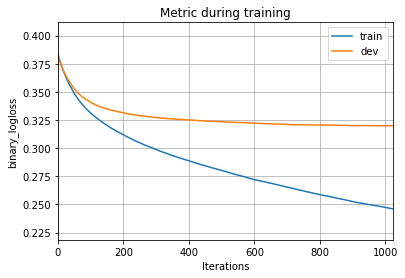

In [187]:
# loss visualisation

# logloss
ax = lgb.plot_metric(eval_dict, metric='binary_logloss')
plt.show()

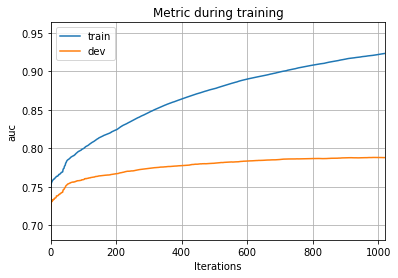

In [188]:
# auc
ax = lgb.plot_metric(eval_dict, metric='auc')
plt.show()

In [189]:
# Generate propensity scores given an input dataframe X and a trained model.
y_pred_prob = lgb_model.predict(X_test)

In [190]:
def evaluation_metrics(y_test, y_pred_prob, threshold=0.5):
    
    # ---- Prepare data ----
    
    # convert y_test to array
    y_test = np.asarray(y_test)
    
    # generate predicted class based on threshold
    y_pred_class = np.where(y_pred_prob >= threshold, 1, 0)
    
    # ---- Generate evaluation metrics ----

    # create dictionary
    eval_dict = dict()
    
    # generate accuracy metric
    eval_dict['accuracy'] = accuracy_score(y_test, y_pred_class)
    
    # generate recall metric
    eval_dict['recall'] = recall_score(y_test, y_pred_class)
    
    # generate precision metric
    eval_dict['precision'] = precision_score(y_test, y_pred_class)
    
    # generate f1 metric
    eval_dict['f1'] = f1_score(y_test, y_pred_class)
    
    # generate AUC ROC
    eval_dict['roc_auc'] = roc_auc_score(y_test, y_pred_prob)
    
    return eval_dict

In [191]:
# generate evaluation metrics dictionary

evaluation_dict = evaluation_metrics(y_test, y_pred_prob, threshold=0.5)
evaluation_dict

{'accuracy': 0.8677512886597938,
 'recall': 0.08736717827626919,
 'precision': 0.6065573770491803,
 'f1': 0.15273477812177502,
 'roc_auc': 0.7943946474241026}

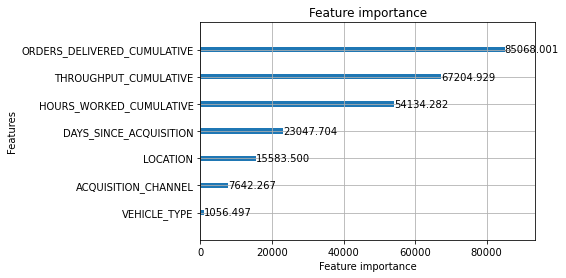

In [192]:
# It seems as though orders delivered, throughput cumulative, and hours worked seem to be the most important predictors. 


# Top 20 most important features
lgb_feature_importance = pd.DataFrame(data = {'name': lgb_model.feature_name(), 
                                              'gain_importance': list(lgb_model.feature_importance(importance_type='gain')),
                                              'split_importance': list(lgb_model.feature_importance(importance_type='split'))
                                             })

lgb_feature_importance = lgb_feature_importance.sort_values(by=['gain_importance'], ascending = False)
lgb_feature_importance.head(n=20)


# Features with 0.0 gain importance
lgb_zero_gain_feat_import = lgb_feature_importance[lgb_feature_importance['gain_importance'] == 0.0]

# Features with 0 split importance
lgb_zero_split_feat_import = lgb_feature_importance[lgb_feature_importance['split_importance'] == 0]

# plotting top 10 most important features
ax = lgb.plot_importance(lgb_model, max_num_features=10, importance_type= 'gain')
plt.show()

In [ ]:
# Generate propensity scores given an input dataframe X and a trained model.
y_prop_score = lgb_model.predict(X)

# keep in mind that you've counted multiple users multiple times
y_prop_label = np.where(y_prop_score >= 0.5, 1, 0)

In [ ]:
data['y_prop_score'] = y_prop_score
data['y_prop_label'] = y_prop_label

In [ ]:
# data[data['y_prop_label']==1]
# a couple riders come multiple times
data['REFERRALS_CUMULATIVE'][data['y_prop_label']==1].value_counts()

We know that boosted trees are sensitive to outliers let's see if excluding those outliers helps performance

In [291]:
# outliers

params = { 'learning_rate' : 0.01,
           'num_iterations' : 1500,
           'objective' : 'binary',
           'early_stopping_round': 50, 
           'metric': ['auc', 'binary_logloss'], # ['auc', 'binary_logloss'] - if both listed, it uses auc
           'num_leaves': 50
}

# Create LightGBM datatset formula
train_lgb = lgb.Dataset(X_train_out, label = y_train_out, categorical_feature = categorical_features)
dev_lgb = lgb.Dataset(X_dev_out, label = y_dev_out, categorical_feature = categorical_features)

# Train model
eval_dict = {} # Empty dictionary to store evaluation results for plotting.
lgb_model = lgb.train(
                params, 
                train_set = train_lgb, 
                categorical_feature=categorical_features,
                valid_sets= [train_lgb, dev_lgb], #validate on training and validation data, order doesn't seem to matter
                valid_names = ['train', 'dev'],
                verbose_eval = 100, #prints every x lines
                evals_result = eval_dict # This dictionary used to store all evaluation results of all the items in valid_sets
                )

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 2404, number of negative: 16160
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 788
[LightGBM] [Info] Number of data points in the train set: 18564, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.129498 -> initscore=-1.905405
[LightGBM] [Info] Start training from score -1.905405
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.799453	train's binary_logloss: 0.331583	dev's auc: 0.752974	dev's binary_logloss: 0.347067
[200]	train's auc: 0.823543	train's binary_logloss: 0.312254	dev's auc: 0.766789	dev's binary_logloss: 0.336866
[300]	train's auc: 0.844666	train's binary_logloss: 0.299081	dev's auc: 0.773428	dev's binary_logloss: 0.332318
[400]	train's auc: 0.863239	train's binary_logloss: 0.288572	dev's auc: 0.779393	dev's binary_logloss: 0.3290

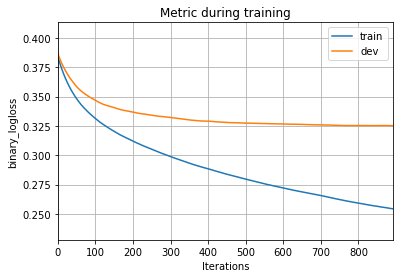

In [194]:
# loss visualisation

# logloss
ax = lgb.plot_metric(eval_dict, metric='binary_logloss')
plt.show()

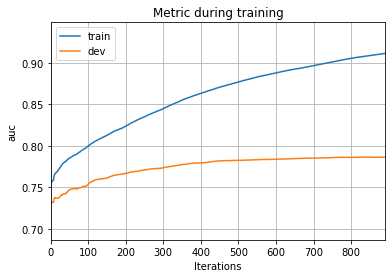

In [195]:
# auc
ax = lgb.plot_metric(eval_dict, metric='auc')
plt.show()

In [196]:
# Generate propensity scores given an input dataframe X and a trained model.
y_pred_prob_out = lgb_model.predict(X_test_out)

In [197]:
# evaluation metrics
evaluation_metrics(y_test_out, y_pred_prob_out, threshold=0.5)


{'accuracy': 0.8763936015511391,
 'recall': 0.07911802853437094,
 'precision': 0.5258620689655172,
 'f1': 0.1375422773393461,
 'roc_auc': 0.8030055696556467}

In [ ]:
# for outliers
# Generate propensity scores given an input dataframe X and a trained model.
y_prop_score_out = lgb_model.predict(X)

# keep in mind that you've counted multiple users multiple times
y_prop_label_out = np.where(y_prop_score_out >= 0.5, 1, 0)
data['y_prop_score_out'] = y_prop_score_out
data['y_prop_label_out'] = y_prop_label_out

In [294]:
# total number of referrals for those with a propensity to refer
data['REFERRALS_CUMULATIVE'][data['y_prop_label_out']==1].value_counts()

1.0     254
2.0     150
3.0      76
4.0      33
5.0      13
       ... 
20.0      1
12.0      1
41.0      1
17.0      1
24.0      1
Name: REFERRALS_CUMULATIVE, Length: 16, dtype: int64

We ran a bayesian optimization but found that it gave us worse results. For the sake of time we have excluded the analysis.

In [199]:
# N_FOLDS = 10
# MAX_EVALS = 25

# # Create the dataset
# train_lgb = lgb.Dataset(X_train, label = y_train, categorical_feature = categorical_features, free_raw_data=False)

# def objective(params, n_folds = N_FOLDS):
#     """Objective function for Gradient Boosting Machine Hyperparameter Tuning"""
    
#     # Perform n_fold cross validation with hyperparameters
#     # Use early stopping and evalute based on ROC AUC
#     cv_results = lgb.cv(params, train_lgb, nfold = n_folds, num_boost_round = 10000, 
#                         early_stopping_rounds = 100, metrics = 'auc', seed = 42)
  
#     # Extract the best score
#     best_score = max(cv_results['auc-mean'])
    
#     # Loss must be minimized
#     loss = 1 - best_score
    
#     # Dictionary with information for evaluation
#     return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [200]:
# space = {
#     'num_leaves': scope.int(hp.quniform('num_leaves', 30, 150, 1)),
#     'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2))
# }

In [201]:
#  # Class to track progress
# bayes_trials = Trials()

In [202]:
# # Optimize
# best = fmin(fn = objective, space = space, algo = tpe.suggest, 
#             max_evals = MAX_EVALS, trials = bayes_trials)

In [203]:
# params = { 'learning_rate': best['learning_rate'],
#            'num_iterations' : 1500,
#            'objective' : 'binary',
#            'early_stopping_round': 50, #early stopping is bound to metric, keeps from overfitting. Which means you can fix a large num_iterations without worrying about overfitting.
#            'metric': ['binary_logloss','auc'], # if no metric is defined, will use default, logloss in this case - ['auc', 'binary_logloss'] - if both listed, it uses auc
#            'num_leaves': best['num_leaves'].astype(int)
#          }

# # Create LightGBM datatset formula
# train_lgb = lgb.Dataset(X_train, label = y_train, categorical_feature = categorical_features)
# dev_lgb = lgb.Dataset(X_dev, label = y_dev, categorical_feature = categorical_features)

# # Train model
# eval_dict = {} # Empty dictionary to store evaluation results for plotting.
# lgb_model = lgb.train(
#                 params, 
#                 train_set = train_lgb, 
#                 categorical_feature=categorical_features,
#                 valid_sets= [train_lgb, dev_lgb], #validate on training and validation data, order doesn't seem to matter
#                 valid_names = ['train', 'dev'],
#                 verbose_eval = 100, #prints every x lines
#                 evals_result = eval_dict # This dictionary used to store all evaluation results of all the items in valid_sets
#                 )

In [204]:
# # Generate propensity scores given an input dataframe X and a trained model.
# y_pred_prob = lgb_model.predict(X_test)
# evaluation_dict = evaluation_metrics(y_test, y_pred_prob, threshold=0.5)
# evaluation_dict

We're going to try one more model we try and look at the propensity to make a successful referral

In [222]:
# successful

# High num_iterations + early stopping rounds (early stopping rounds depends on data size)
# num steps = training size / batch size 

params = { 'learning_rate' : 0.01,
           'num_iterations' : 1500,
           'objective' : 'binary',
           'early_stopping_round': 50, 
           'metric': ['auc', 'binary_logloss'], # ['auc', 'binary_logloss'] - if both listed, it uses auc
           'num_leaves': 50
}

# Create LightGBM datatset formula
train_lgb = lgb.Dataset(X_train, label = y_train_succ, categorical_feature = categorical_features)
dev_lgb = lgb.Dataset(X_dev, label = y_dev_succ, categorical_feature = categorical_features)

# Train model
eval_dict = {} # Empty dictionary to store evaluation results for plotting.
lgb_model = lgb.train(
                params, 
                train_set = train_lgb, 
                categorical_feature=categorical_features,
                valid_sets= [train_lgb, dev_lgb], #validate on training and validation data, order doesn't seem to matter
                valid_names = ['train', 'dev'],
                verbose_eval = 100, #prints every x lines
                evals_result = eval_dict # This dictionary used to store all evaluation results of all the items in valid_sets
                )

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 755, number of negative: 17867
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 788
[LightGBM] [Info] Number of data points in the train set: 18622, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.040543 -> initscore=-3.163993
[LightGBM] [Info] Start training from score -3.163993
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.895678	train's binary_logloss: 0.130011	dev's auc: 0.851586	dev's binary_logloss: 0.130612
[200]	train's auc: 0.924001	train's binary_logloss: 0.115421	dev's auc: 0.855271	dev's binary_logloss: 0.124646
Early stopping, best iteration is:
[163]	train's auc: 0.91417	train's binary_logloss: 0.119914	dev's auc: 0.856545	dev's binary_logloss: 0.125903


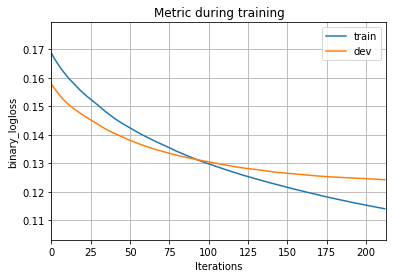

In [223]:
# loss visualisation

# logloss
ax = lgb.plot_metric(eval_dict, metric='binary_logloss')
plt.show()

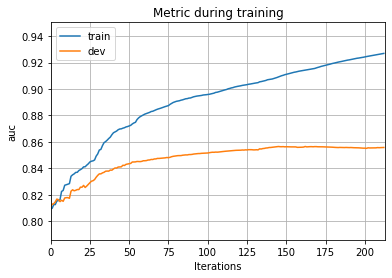

In [224]:
# auc
ax = lgb.plot_metric(eval_dict, metric='auc')
plt.show()


In [225]:
# look at evaluation metrics
y_pred_succ = lgb_model.predict(X_test)

evaluation_metrics(y_test_succ, y_pred_succ, threshold=0.5)

{'accuracy': 0.9610180412371134,
 'recall': 0.00819672131147541,
 'precision': 1.0,
 'f1': 0.016260162601626018,
 'roc_auc': 0.8232774378511507}

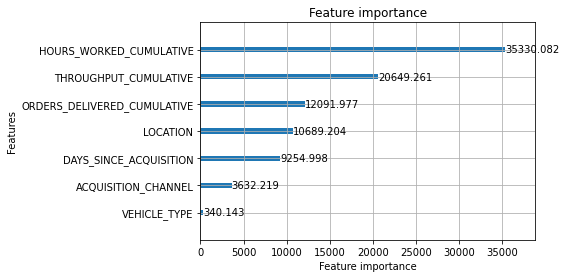

In [226]:
# Top 20 most important features
# hours worked has become a more important feature
lgb_feature_importance = pd.DataFrame(data = {'name': lgb_model.feature_name(), 
                                              'gain_importance': list(lgb_model.feature_importance(importance_type='gain')),
                                              'split_importance': list(lgb_model.feature_importance(importance_type='split'))
                                             })

lgb_feature_importance = lgb_feature_importance.sort_values(by=['gain_importance'], ascending = False)
lgb_feature_importance.head(n=20)


# Features with 0.0 gain importance
lgb_zero_gain_feat_import = lgb_feature_importance[lgb_feature_importance['gain_importance'] == 0.0]

# Features with 0 split importance
lgb_zero_split_feat_import = lgb_feature_importance[lgb_feature_importance['split_importance'] == 0]

# plotting top 10 most important features
ax = lgb.plot_importance(lgb_model, max_num_features=10, importance_type= 'gain')
plt.show()

In [228]:
# for successful prediction
# 0.25 for success, at 0.5 there were only 9
# Generate propensity scores given an input dataframe X and a trained model.
y_prop_score_succ = lgb_model.predict(X)

# keep in mind that you've counted multiple users multiple times
y_prop_label_succ = np.where(y_prop_score_succ >= 0.3, 1, 0)

data['y_prop_score_succ'] = y_prop_score_succ
data['y_prop_label_succ'] = y_prop_label_succ

In [229]:
data['y_prop_label_succ'].value_counts()

0    30889
1      149
Name: y_prop_label_succ, dtype: int64

In [230]:
# those with a label of having a propensity to successfully refer

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

data_prop_succ = data[data['y_prop_label_succ']==1]
data_prop_succ

RIDER_ID  LOCATION               APPLICATION_DATE      APPLICATION_APPROVED_DATE FIRST_WORK_DATE ACQUISITION_CHANNEL          VEHICLE_TYPE  DAYS_SINCE_ACQUISITION  HOURS_WORKED_CUMULATIVE  ORDERS_DELIVERED_CUMULATIVE  THROUGHPUT_CUMULATIVE  REFERRALS_CUMULATIVE  SUCCESSFUL_REFERRALS_CUMULATIVE  REFERRALS_CUMULATIVE_IMP  SUCCESSFUL_REFERRALS_CUMULATIVE_IMP  y_prop_score  y_prop_label  y_prop_score_out  y_prop_label_out  y_prop_score_succ  y_prop_label_succ
733      101383  Roo York  2015-02-06 00:00:00.000000000  2017-03-19 00:00:00.000000000      2017-03-19            Referral  Scooter / Motorcycle                     168                    367.1                         1078                   2.94                   1.0                              1.0                      True                                 True      0.549828             1          0.549828                 1           0.303659                  1
874       96970  Roo York  2017-01-27 00:00:00.000000000  2017-02-21 00:00:00.000000000      2017-02-22            Referral               Bicycle                     168                    146.9                          421                   2.87                   NaN                              NaN                     False                                False      0.423519             0          0.423519                 0           0.334443                  1
1374     100988  Roo York  2016-08-17 00:00:00.000000000  2017-03-18 00:00:00.000000000      2017-03-18            Referral  Scooter / Motorcycle                     168                    397.8                         1230                   3.09                   2.0                              1.0                      True                                 True      0.706699             1          0.706699                 1           0.336459                  1
1687      67648  Roo York  2015-09-05 00:00:00.000000000  2016-10-18 00:00:00.000000000      2016-10-21             Offline  Scooter / Motorcycle                     168                    408.5                          605                   1.48                   2.0                              2.0                      True                                 True      0.559925             1          0.559925                 1           0.304596                  1
1766     102968  Roo York  2017-03-12 00:00:00.000000000  2017-05-15 00:00:00.000000000      2017-03-30            Referral  Scooter / Motorcycle                     168                   1096.6                         2868                   2.62                   2.0                              1.0                      True                                 True      0.666850             1          0.666850                 1           0.314591                  1
...         ...       ...                            ...                            ...             ...                 ...                   ...                     ...                      ...                          ...                    ...                   ...                              ...                       ...                                  ...           ...           ...               ...               ...                ...                ...
29805     77300  Roo York  2016-10-21 00:00:00.000000000  2016-11-22 00:00:00.000000000      2017-02-08             Offline  Scooter / Motorcycle                     168                    388.5                         1109                   2.85                   2.0                              0.0                      True                                False      0.424546             0          0.424546                 0           0.324882                  1
30370     71421  Roo York  2016-10-28 00:00:00.000000000  2016-10-31 00:00:00.000000000      2016-11-04             Organic               Bicycle                      56                     47.3                          109                   2.30                   1.0   

Let's explore the subset of users who successfully refer. First let's take out only the user observations at 168 hours



In [231]:
data_prop_succ_max = data_prop_succ[data_prop_succ['DAYS_SINCE_ACQUISITION']==168]
data_prop_succ_max


RIDER_ID  LOCATION               APPLICATION_DATE      APPLICATION_APPROVED_DATE FIRST_WORK_DATE ACQUISITION_CHANNEL          VEHICLE_TYPE  DAYS_SINCE_ACQUISITION  HOURS_WORKED_CUMULATIVE  ORDERS_DELIVERED_CUMULATIVE  THROUGHPUT_CUMULATIVE  REFERRALS_CUMULATIVE  SUCCESSFUL_REFERRALS_CUMULATIVE  REFERRALS_CUMULATIVE_IMP  SUCCESSFUL_REFERRALS_CUMULATIVE_IMP  y_prop_score  y_prop_label  y_prop_score_out  y_prop_label_out  y_prop_score_succ  y_prop_label_succ
733      101383  Roo York  2015-02-06 00:00:00.000000000  2017-03-19 00:00:00.000000000      2017-03-19            Referral  Scooter / Motorcycle                     168                    367.1                         1078                   2.94                   1.0                              1.0                      True                                 True      0.549828             1          0.549828                 1           0.303659                  1
874       96970  Roo York  2017-01-27 00:00:00.000000000  2017-02-21 00:00:00.000000000      2017-02-22            Referral               Bicycle                     168                    146.9                          421                   2.87                   NaN                              NaN                     False                                False      0.423519             0          0.423519                 0           0.334443                  1
1374     100988  Roo York  2016-08-17 00:00:00.000000000  2017-03-18 00:00:00.000000000      2017-03-18            Referral  Scooter / Motorcycle                     168                    397.8                         1230                   3.09                   2.0                              1.0                      True                                 True      0.706699             1          0.706699                 1           0.336459                  1
1687      67648  Roo York  2015-09-05 00:00:00.000000000  2016-10-18 00:00:00.000000000      2016-10-21             Offline  Scooter / Motorcycle                     168                    408.5                          605                   1.48                   2.0                              2.0                      True                                 True      0.559925             1          0.559925                 1           0.304596                  1
1766     102968  Roo York  2017-03-12 00:00:00.000000000  2017-05-15 00:00:00.000000000      2017-03-30            Referral  Scooter / Motorcycle                     168                   1096.6                         2868                   2.62                   2.0                              1.0                      True                                 True      0.666850             1          0.666850                 1           0.314591                  1
...         ...       ...                            ...                            ...             ...                 ...                   ...                     ...                      ...                          ...                    ...                   ...                              ...                       ...                                  ...           ...           ...               ...               ...                ...                ...
29156    100707  Roo York  2015-03-01 00:00:00.000000000  2017-03-14 00:00:00.000000000      2017-03-14            Referral  Scooter / Motorcycle                     168                    840.4                         2271                   2.70                   3.0                              2.0                      True                                 True      0.723418             1          0.723418                 1           0.311602                  1
29412     96783  Roo York  2017-02-18 00:00:00.000000000  2017-02-21 00:00:00.000000000      2017-02-22             Organic               Bicycle                     168                     46.5                          109                   2.34                   2.0   

In [232]:
# where are my riders
data_prop_succ_max['LOCATION'].value_counts()

Roo York          111
Roo Town            1
Roo de Janeiro      0
Name: LOCATION, dtype: int64

<AxesSubplot:ylabel='HOURS_WORKED_CUMULATIVE'>

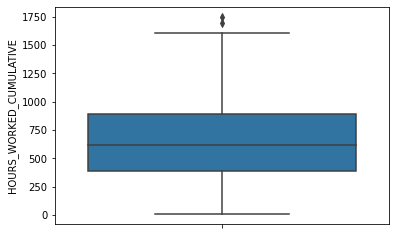

In [233]:
# decided to lump them all together since all my riders seemed to be from Roo York
# average hours worked cumulative by workers that successfully refer is so much higher
sns.boxplot(y='HOURS_WORKED_CUMULATIVE', data=data_prop_succ_max)

<AxesSubplot:ylabel='HOURS_WORKED_CUMULATIVE'>

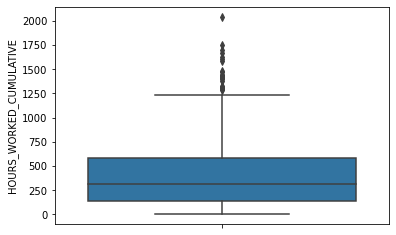

In [234]:
# let's look at riders who have simply referred
data_prop_ref = data[data['y_prop_label']==1]

# median number of hours worked is lower than successfully referred, but higher than population
sns.boxplot(y='HOURS_WORKED_CUMULATIVE', data=data_prop_ref)

#### 4. Hierarchical clustering
Let's do a bit of rough hierarchical clustering. We start by grabbing the right data. 

Will only use data at 168 days worked at Deliveroo for simplicity and to avoid duplicates.


In [236]:
# Using data_max - so only 

dend_data = pd.DataFrame(data_max.iloc[:, [8,9,10,11]].values)
dend_data = dend_data.rename(columns={0: "HOURS_WORKED_CUMULATIVE", 1: "ORDERS_DELIVERED_CUMULATIVE", 2: "THROUGHPUT_CUMULATIVE", 3: "REFERRAL_IMP"})
dend_data


# add in referrals imputed with 0
dend_data["REFERRAL_IMP"] = dend_data['REFERRAL_IMP'].apply(lambda x: x if x >= 1 else '0')

# normalize data
x = dend_data.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
dend_data_scaled = min_max_scaler.fit_transform(x)
dend_data_norm = pd.DataFrame(dend_data_scaled)
dend_data_norm = dend_data_norm.rename(columns={0: "HOURS_WORKED_CUMULATIVE", 1: "ORDERS_DELIVERED_CUMULATIVE", 2: "THROUGHPUT_CUMULATIVE", 3: "REFERRAL_IMP"})
dend_data_norm




HOURS_WORKED_CUMULATIVE  ORDERS_DELIVERED_CUMULATIVE  THROUGHPUT_CUMULATIVE  REFERRAL_IMP
0                    0.016257                     0.008031               0.230769      0.000000
1                    0.027030                     0.018122               0.313609      0.000000
2                    0.467192                     0.361614               0.362919      0.006993
3                    0.059054                     0.063221               0.500986      0.006993
4                    0.176280                     0.096582               0.256410      0.000000
...                       ...                          ...                    ...           ...
5168                 0.021105                     0.019769               0.437870      0.000000
5169                 0.068260                     0.075165               0.514793      0.000000
5170                 0.070757                     0.055601               0.368836      0.000000
5171                 0.008961                     0.009267               0.479290      0.000000
5172                 0.032759                     0.029860               0.426036      0.000000

[5173 rows x 4 columns]

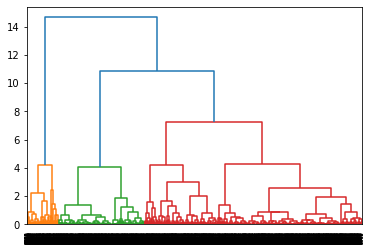

In [237]:
# Naive agglomerative clustering
dendrogram = sch.dendrogram(sch.linkage(dend_data_norm, method='ward'))

In [238]:
dend_model = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
dend_model.fit(dend_data_norm)
labels = dend_model.labels_

# frequencies of clusters
(unique, counts) = np.unique(labels, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

array([[   0, 3346],
       [   1,  488],
       [   2, 1339]])

In [239]:
# extract dendrogram labels
dend_labels = pd.DataFrame(labels)

In [240]:
# added dendrogram label to normalised data so I can extract rider id and dendrogram label side by side
dend_data_norm['DEND_LABEL'] = dend_labels

In [241]:
test = data_max['RIDER_ID'].to_numpy()

dend_labels_rider = pd.concat([dend_data_norm, pd.DataFrame(test)], axis=1)
dend_labels_rider = dend_labels_rider.rename(columns={0: "RIDER_ID"})
rider_and_label = dend_labels_rider[['RIDER_ID', 'DEND_LABEL']].astype(int)
rider_and_label

RIDER_ID  DEND_LABEL
0        73350           2
1        84888           2
2        67542           1
3        83695           0
4        68279           0
...        ...         ...
5168     79222           0
5169     68023           0
5170     66030           0
5171     76089           0
5172    101217           0

[5173 rows x 2 columns]

In [242]:
# merge dendrogram label with datasets
data_max_clust = data_max.merge(rider_and_label, how='inner', on='RIDER_ID')

In [243]:
# we now need to look at these clusters and see if they tell us anything about our cohorts. 
# Ideally they fall in line with some of our assumptions

cluster1 = data_max_clust[data_max_clust['DEND_LABEL']==0] # our advocates
cluster2 = data_max_clust[data_max_clust['DEND_LABEL']==1] # our pros
cluster3 = data_max_clust[data_max_clust['DEND_LABEL']==2] # our dabblers

In [244]:
# cluster 1: summary
cluster1.describe()

RIDER_ID  DAYS_SINCE_ACQUISITION  HOURS_WORKED_CUMULATIVE  ORDERS_DELIVERED_CUMULATIVE  THROUGHPUT_CUMULATIVE  REFERRALS_CUMULATIVE  SUCCESSFUL_REFERRALS_CUMULATIVE  y_prop_score  y_prop_label  y_prop_score_out  y_prop_label_out  DEND_LABEL
count    3346.000000                  3346.0              3346.000000                  3346.000000            3346.000000            877.000000                       877.000000   3346.000000   3346.000000       3346.000000       3346.000000      3346.0
mean    82317.650030                   168.0               170.703497                   372.727735               2.246324              2.833523                         0.567845      0.258582      0.091452          0.258582          0.091452         0.0
std     12801.652351                     0.0               165.410249                   356.754277               0.466667             10.213681                         1.230887      0.162903      0.288295          0.162903          0.288295         0.0
min      5276.000000                   168.0                 0.400000                     1.000000               0.650000              1.000000                         0.000000      0.004900      0.000000          0.004900          0.000000         0.0
25%     72524.750000                   168.0                40.300000                    91.000000               1.912500              1.000000                         0.000000      0.129794      0.000000          0.129794          0.000000         0.0
50%     79508.500000                   168.0               113.400000                   251.000000               2.230000              2.000000                         0.000000      0.240326      0.000000          0.240326          0.000000         0.0
75%     95780.000000                   168.0               259.075000                   559.000000               2.550000              3.000000                         1.000000      0.370263      0.000000          0.370263          0.000000         0.0
max    103776.000000                   168.0              1078.000000                  1725.000000               5.070000            286.000000                        27.000000      0.819508      1.000000          0.819508          1.000000         0.0

<AxesSubplot:ylabel='ORDERS_DELIVERED_CUMULATIVE'>

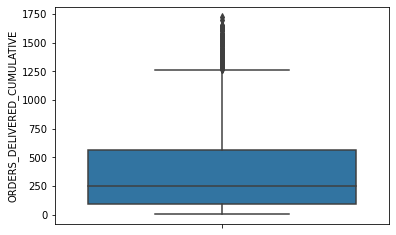

In [245]:
# cluster1: orders delivered
sns.boxplot(y='ORDERS_DELIVERED_CUMULATIVE', data=cluster1)

<AxesSubplot:ylabel='HOURS_WORKED_CUMULATIVE'>

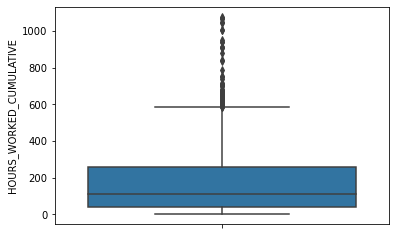

In [246]:
# cluster 1: hours worked
sns.boxplot(y='HOURS_WORKED_CUMULATIVE', data=cluster1)

<AxesSubplot:ylabel='REFERRALS_CUMULATIVE'>

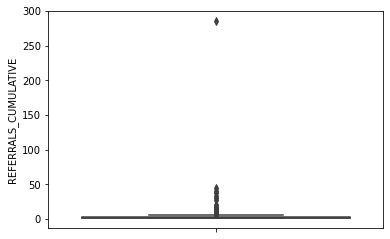

In [247]:
# cluster 1: referrals
sns.boxplot(y='REFERRALS_CUMULATIVE', data=cluster1)


In [248]:
# cluster 2: summary
cluster2.describe()

RIDER_ID  DAYS_SINCE_ACQUISITION  HOURS_WORKED_CUMULATIVE  ORDERS_DELIVERED_CUMULATIVE  THROUGHPUT_CUMULATIVE  REFERRALS_CUMULATIVE  SUCCESSFUL_REFERRALS_CUMULATIVE  y_prop_score  y_prop_label  y_prop_score_out  y_prop_label_out  DEND_LABEL
count     488.000000                   488.0               488.000000                   488.000000             488.000000            216.000000                       216.000000    488.000000    488.000000        488.000000        488.000000       488.0
mean    83315.014344                   168.0               831.486066                  1957.012295               2.393279              2.592593                         0.703704      0.426277      0.387295          0.426277          0.387295         1.0
std     13719.262613                     0.0               266.020255                   645.852333               0.443175              2.693790                         0.990741      0.179410      0.487632          0.179410          0.487632         0.0
min      1864.000000                   168.0               503.200000                  1069.000000               0.820000              1.000000                         0.000000      0.019584      0.000000          0.019584          0.000000         1.0
25%     72221.250000                   168.0               622.750000                  1458.000000               2.130000              1.000000                         0.000000      0.287120      0.000000          0.287120          0.000000         1.0
50%     81278.500000                   168.0               763.000000                  1846.000000               2.410000              2.000000                         0.000000      0.444909      0.000000          0.444909          0.000000         1.0
75%     96868.000000                   168.0               974.650000                  2283.500000               2.680000              3.000000                         1.000000      0.579249      1.000000          0.579249          1.000000         1.0
max    103762.000000                   168.0              2042.400000                  4856.000000               3.680000             24.000000                         6.000000      0.754034      1.000000          0.754034          1.000000         1.0

<AxesSubplot:ylabel='ORDERS_DELIVERED_CUMULATIVE'>

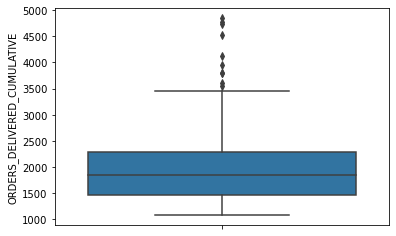

In [249]:
# cluster 2: orders delivered
sns.boxplot(y='ORDERS_DELIVERED_CUMULATIVE', data=cluster2)

<AxesSubplot:ylabel='HOURS_WORKED_CUMULATIVE'>

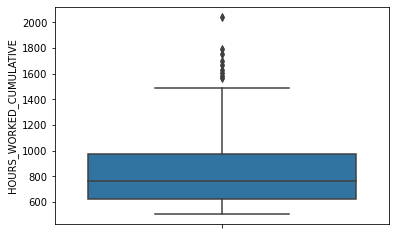

In [250]:
# cluster 2: hours worked
sns.boxplot(y='HOURS_WORKED_CUMULATIVE', data=cluster2)

<AxesSubplot:ylabel='REFERRALS_CUMULATIVE'>

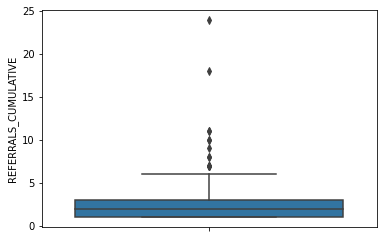

In [251]:
# cluster 2: referrals
sns.boxplot(y='REFERRALS_CUMULATIVE', data=cluster2)


In [252]:
# cluster 3: summary
cluster3.describe()

RIDER_ID  DAYS_SINCE_ACQUISITION  HOURS_WORKED_CUMULATIVE  ORDERS_DELIVERED_CUMULATIVE  THROUGHPUT_CUMULATIVE  REFERRALS_CUMULATIVE  SUCCESSFUL_REFERRALS_CUMULATIVE  y_prop_score  y_prop_label  y_prop_score_out  y_prop_label_out  DEND_LABEL
count    1339.000000                  1339.0              1339.000000                  1339.000000            1339.000000            179.000000                       179.000000   1339.000000   1339.000000       1339.000000       1339.000000      1339.0
mean    76610.007468                   168.0                56.771023                    59.223301               1.069149              1.765363                         0.424581      0.128745      0.026886          0.128745          0.026886         2.0
std     11289.230219                     0.0                67.726782                    62.526492               0.475614              1.366010                         0.607684      0.135912      0.161810          0.135912          0.161810         0.0
min      3062.000000                   168.0                 0.200000                     0.000000               0.000000              1.000000                         0.000000      0.002446      0.000000          0.002446          0.000000         2.0
25%     68737.500000                   168.0                10.000000                     9.000000               0.770000              1.000000                         0.000000      0.029107      0.000000          0.029107          0.000000         2.0
50%     73732.000000                   168.0                32.900000                    35.000000               1.180000              1.000000                         0.000000      0.080387      0.000000          0.080387          0.000000         2.0
75%     81208.500000                   168.0                80.300000                    92.000000               1.450000              2.000000                         1.000000      0.187573      0.000000          0.187573          0.000000         2.0
max    103691.000000                   168.0               486.500000                   353.000000               1.730000              9.000000                         3.000000      0.756844      1.000000          0.756844          1.000000         2.0

<AxesSubplot:ylabel='ORDERS_DELIVERED_CUMULATIVE'>

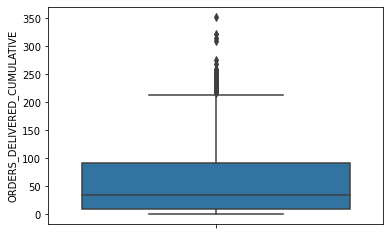

In [253]:
# cluster 3: orders delvered
sns.boxplot(y='ORDERS_DELIVERED_CUMULATIVE', data=cluster3)

<AxesSubplot:ylabel='HOURS_WORKED_CUMULATIVE'>

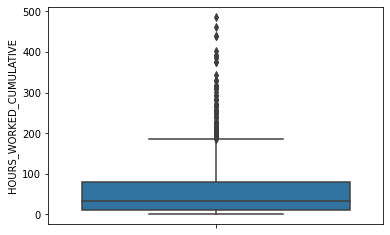

In [254]:
# cluster 3: hours worked
sns.boxplot(y='HOURS_WORKED_CUMULATIVE', data=cluster3)

<AxesSubplot:ylabel='REFERRALS_CUMULATIVE'>

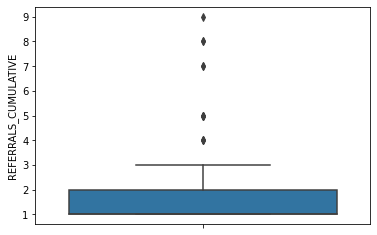

In [255]:
# cluster 3: referrals
sns.boxplot(y='REFERRALS_CUMULATIVE', data=cluster3)


I want to look at the relationship between the clusters we've created and the number of referrals.

In [256]:
# Riders that have sent three or more : 200 riders
ref_four_more = data_max_clust[data_max_clust['REFERRALS_CUMULATIVE'] > 3]

# riders that have sent two or three: 343 riders
ref_two_three = data_max_clust[(data_max_clust['REFERRALS_CUMULATIVE'] > 0) & (data_max_clust['REFERRALS_CUMULATIVE'] >= 3)]

# riders that have sent one: 624
ref_one = data_max_clust[data_max_clust['REFERRALS_CUMULATIVE'] == 1]

# riders that have sent none
riders_no_ref = data_max_clust[pd.isnull(data_max_clust['REFERRALS_CUMULATIVE'])]

In [257]:
# clusters in four or more referrals
print(ref_four_more['DEND_LABEL'].value_counts(),"\n", ref_four_more['DEND_LABEL'].value_counts() / ref_four_more['DEND_LABEL'].value_counts().sum())


0    141
1     48
2     12
Name: DEND_LABEL, dtype: int64 
 0    0.701493
1    0.238806
2    0.059701
Name: DEND_LABEL, dtype: float64


In [295]:
# summary stats for those that have made four or more referrals
ref_four_more.describe()

RIDER_ID  DAYS_SINCE_ACQUISITION  HOURS_WORKED_CUMULATIVE  ORDERS_DELIVERED_CUMULATIVE  THROUGHPUT_CUMULATIVE  REFERRALS_CUMULATIVE  SUCCESSFUL_REFERRALS_CUMULATIVE  y_prop_score  y_prop_label  y_prop_score_out  y_prop_label_out  DEND_LABEL
count     201.000000                   201.0               201.000000                   201.000000             201.000000            201.000000                       201.000000    201.000000    201.000000        201.000000        201.000000  201.000000
mean    85968.636816                   168.0               427.098010                   937.004975               2.213731              8.462687                         1.497512      0.438080      0.343284          0.438080          0.343284    0.358209
std     13472.344149                     0.0               339.636051                   790.307633               0.632242             20.592471                         2.278430      0.152881      0.475991          0.152881          0.475991    0.592490
min     33023.000000                   168.0                 7.100000                     1.000000               0.090000              4.000000                         0.000000      0.087968      0.000000          0.087968          0.000000    0.000000
25%     74109.000000                   168.0               168.700000                   375.000000               1.840000              4.000000                         0.000000      0.329921      0.000000          0.329921          0.000000    0.000000
50%     84717.000000                   168.0               366.800000                   682.000000               2.290000              5.000000                         1.000000      0.437792      0.000000          0.437792          0.000000    0.000000
75%     98370.000000                   168.0               596.700000                  1271.000000               2.680000              7.000000                         2.000000      0.557425      1.000000          0.557425          1.000000    1.000000
max    103775.000000                   168.0              1697.700000                  4777.000000               3.770000            286.000000                        27.000000      0.754034      1.000000          0.754034          1.000000    2.000000

In [259]:
# clusters in two/three referrals
print(ref_two_three['DEND_LABEL'].value_counts(),"\n", ref_two_three['DEND_LABEL'].value_counts() / ref_two_three['DEND_LABEL'].value_counts().sum())


0    250
1     64
2     29
Name: DEND_LABEL, dtype: int64 
 0    0.728863
1    0.186589
2    0.084548
Name: DEND_LABEL, dtype: float64


In [260]:
# summary stats for those that have made two or three referrals
ref_two_three.describe()

RIDER_ID  DAYS_SINCE_ACQUISITION  HOURS_WORKED_CUMULATIVE  ORDERS_DELIVERED_CUMULATIVE  THROUGHPUT_CUMULATIVE  REFERRALS_CUMULATIVE  SUCCESSFUL_REFERRALS_CUMULATIVE  y_prop_score  y_prop_label  y_prop_score_out  y_prop_label_out  DEND_LABEL
count     343.000000                   343.0               343.000000                   343.000000             343.000000            343.000000                       343.000000    343.000000    343.000000        343.000000        343.000000  343.000000
mean    84902.087464                   168.0               381.669679                   844.521866               2.204810              6.201166                         1.154519      0.434185      0.358601          0.434185          0.358601    0.355685
std     13130.395980                     0.0               320.600660                   768.188877               0.650125             15.976327                         1.864418      0.155406      0.480290          0.155406          0.480290    0.632008
min     33023.000000                   168.0                 2.500000                     1.000000               0.090000              3.000000                         0.000000      0.035483      0.000000          0.035483          0.000000    0.000000
25%     73381.500000                   168.0               141.900000                   274.500000               1.845000              3.000000                         0.000000      0.315259      0.000000          0.315259          0.000000    0.000000
50%     83234.000000                   168.0               306.100000                   632.000000               2.290000              4.000000                         1.000000      0.432348      0.000000          0.432348          0.000000    0.000000
75%     97861.000000                   168.0               517.300000                  1155.000000               2.685000              5.000000                         2.000000      0.555893      1.000000          0.555893          1.000000    1.000000
max    103775.000000                   168.0              1697.700000                  4777.000000               3.770000            286.000000                        27.000000      0.795936      1.000000          0.795936          1.000000    2.000000

In [261]:
# clusters in one referral
print(ref_one['DEND_LABEL'].value_counts(),"\n", ref_one['DEND_LABEL'].value_counts() / ref_one['DEND_LABEL'].value_counts().sum())


0    425
2    106
1     93
Name: DEND_LABEL, dtype: int64 
 0    0.681090
2    0.169872
1    0.149038
Name: DEND_LABEL, dtype: float64


In [262]:
# summary stats for those that have made one referral
ref_one.describe()

RIDER_ID  DAYS_SINCE_ACQUISITION  HOURS_WORKED_CUMULATIVE  ORDERS_DELIVERED_CUMULATIVE  THROUGHPUT_CUMULATIVE  REFERRALS_CUMULATIVE  SUCCESSFUL_REFERRALS_CUMULATIVE  y_prop_score  y_prop_label  y_prop_score_out  y_prop_label_out  DEND_LABEL
count     624.000000                   624.0               624.000000                   624.000000             624.000000                 624.0                       624.000000    624.000000    624.000000        624.000000        624.000000  624.000000
mean    81516.203526                   168.0               266.504006                   603.350962               2.117676                   1.0                         0.277244      0.389811      0.267628          0.389811          0.267628    0.488782
std     13626.795940                     0.0               276.961343                   697.556773               0.669150                   0.0                         0.447997      0.160226      0.443078          0.160226          0.443078    0.768482
min      1864.000000                   168.0                 0.400000                     0.000000               0.000000                   1.0                         0.000000      0.016768      0.000000          0.016768          0.000000    0.000000
25%     70639.250000                   168.0                60.900000                   118.000000               1.720000                   1.0                         0.000000      0.268103      0.000000          0.268103          0.000000    0.000000
50%     78834.000000                   168.0               166.100000                   330.500000               2.195000                   1.0                         0.000000      0.389021      0.000000          0.389021          0.000000    0.000000
75%     95073.250000                   168.0               407.750000                   860.250000               2.590000                   1.0                         1.000000      0.511219      1.000000          0.511219          1.000000    1.000000
max    103633.000000                   168.0              1438.100000                  4117.000000               3.970000                   1.0                         1.000000      0.819508      1.000000          0.819508          1.000000    2.000000

In [263]:
# clusters in no referral
print(riders_no_ref['DEND_LABEL'].value_counts(),"\n", riders_no_ref['DEND_LABEL'].value_counts() / riders_no_ref['DEND_LABEL'].value_counts().sum())


0    2469
2    1160
1     272
Name: DEND_LABEL, dtype: int64 
 0    0.632915
2    0.297360
1    0.069726
Name: DEND_LABEL, dtype: float64


In [264]:
riders_no_ref.describe()

RIDER_ID  DAYS_SINCE_ACQUISITION  HOURS_WORKED_CUMULATIVE  ORDERS_DELIVERED_CUMULATIVE  THROUGHPUT_CUMULATIVE  REFERRALS_CUMULATIVE  SUCCESSFUL_REFERRALS_CUMULATIVE  y_prop_score  y_prop_label  y_prop_score_out  y_prop_label_out   DEND_LABEL
count    3901.000000                  3901.0              3901.000000                  3901.000000            3901.000000                   0.0                              0.0   3901.000000   3901.000000       3901.000000       3901.000000  3901.000000
mean    80347.430659                   168.0               168.456293                   359.075878               1.894373                   NaN                              NaN      0.186142      0.035376          0.186142          0.035376     0.664445
std     12360.395085                     0.0               236.889412                   549.071405               0.706791                   NaN                              NaN      0.146333      0.184751          0.146333          0.184751     0.904371
min      3062.000000                   168.0                 0.200000                     0.000000               0.000000                   NaN                              NaN      0.002446      0.000000          0.002446          0.000000     0.000000
25%     70889.000000                   168.0                23.200000                    37.000000               1.480000                   NaN                              NaN      0.065066      0.000000          0.065066          0.000000     0.000000
50%     77160.000000                   168.0                71.700000                   128.000000               1.980000                   NaN                              NaN      0.156799      0.000000          0.156799          0.000000     0.000000
75%     92658.000000                   168.0               212.200000                   427.000000               2.390000                   NaN                              NaN      0.275723      0.000000          0.275723          0.000000     2.000000
max    103776.000000                   168.0              2042.400000                  4856.000000               5.070000                   NaN                              NaN      0.733958      1.000000          0.733958          1.000000     2.000000

In [265]:
# summary stats global
data_max_clust.describe()

RIDER_ID  DAYS_SINCE_ACQUISITION  HOURS_WORKED_CUMULATIVE  ORDERS_DELIVERED_CUMULATIVE  THROUGHPUT_CUMULATIVE  REFERRALS_CUMULATIVE  SUCCESSFUL_REFERRALS_CUMULATIVE  y_prop_score  y_prop_label  y_prop_score_out  y_prop_label_out   DEND_LABEL
count    5173.000000                  5173.0              5173.000000                  5173.000000            5173.000000           1272.000000                      1272.000000   5173.000000   5173.000000       5173.000000       5173.000000  5173.000000
mean    80934.348347                   168.0               203.548328                   441.034023               1.955482              2.642296                         0.570755      0.240794      0.102648          0.240794          0.102648     0.612024
std     12778.830459                     0.0               262.726882                   616.608908               0.702890              8.574487                         1.126056      0.177972      0.303528          0.177972          0.303528     0.869071
min      1864.000000                   168.0                 0.200000                     0.000000               0.000000              1.000000                         0.000000      0.002446      0.000000          0.002446          0.000000     0.000000
25%     70990.000000                   168.0                30.600000                    51.000000               1.530000              1.000000                         0.000000      0.086953      0.000000          0.086953          0.000000     0.000000
50%     77741.000000                   168.0                94.100000                   175.000000               2.040000              2.000000                         0.000000      0.208588      0.000000          0.208588          0.000000     0.000000
75%     94220.000000                   168.0               272.200000                   578.000000               2.450000              3.000000                         1.000000      0.360188      0.000000          0.360188          0.000000     2.000000
max    103776.000000                   168.0              2042.400000                  4856.000000               5.070000            286.000000                        27.000000      0.819508      1.000000          0.819508          1.000000     2.000000

<AxesSubplot:ylabel='HOURS_WORKED_CUMULATIVE'>

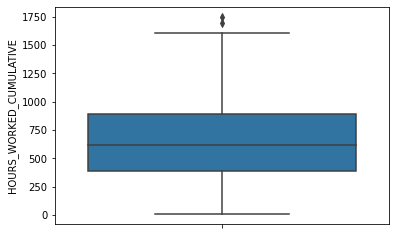

In [279]:
# boxplot for those with a propensity to make a successful referral, total hours worked
sns.boxplot(y=(data_prop_succ_max[data_prop_succ_max['y_prop_label_succ']==1])['HOURS_WORKED_CUMULATIVE'])

In [285]:
# propensity to make a successful referral: hours worked
((data_prop_succ_max[data_prop_succ_max['y_prop_label_succ']==1])['HOURS_WORKED_CUMULATIVE']).describe()

count     112.000000
mean      634.855357
std       401.090039
min         5.100000
25%       386.300000
50%       620.100000
75%       891.325000
max      1749.000000
Name: HOURS_WORKED_CUMULATIVE, dtype: float64

<AxesSubplot:ylabel='THROUGHPUT_CUMULATIVE'>

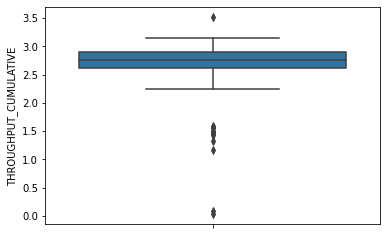

In [281]:
# propensity to make a successful referral: throughput
sns.boxplot(y=(data_prop_succ_max[data_prop_succ_max['y_prop_label_succ']==1])['THROUGHPUT_CUMULATIVE'])



In [286]:
propensity to make a successful referral: throughput summary stats
((data_prop_succ_max[data_prop_succ_max['y_prop_label_succ']==1])['THROUGHPUT_CUMULATIVE']).describe()

count    112.000000
mean       2.612857
std        0.547662
min        0.030000
25%        2.620000
50%        2.765000
75%        2.890000
max        3.520000
Name: THROUGHPUT_CUMULATIVE, dtype: float64

In [276]:
# propensity to make a referral: referral count
(data_max_clust[data_max_clust['y_prop_label']==1])['REFERRALS_CUMULATIVE'].value_counts()

1.0     167
2.0     103
3.0      54
4.0      28
5.0      12
       ... 
20.0      1
12.0      1
41.0      1
17.0      1
24.0      1
Name: REFERRALS_CUMULATIVE, Length: 16, dtype: int64

<AxesSubplot:ylabel='HOURS_WORKED_CUMULATIVE'>

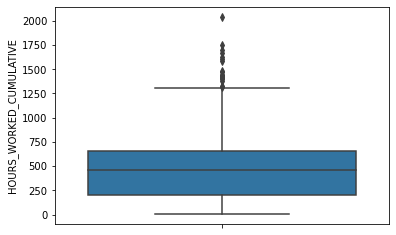

In [280]:
# propensity to make a referral: hours worked boxplot
sns.boxplot(y=(data_max_clust[data_max_clust['y_prop_label']==1])['HOURS_WORKED_CUMULATIVE'])

In [287]:
# propensity to make a referral: hours worked summary stats
((data_max_clust[data_max_clust['y_prop_label']==1])['HOURS_WORKED_CUMULATIVE']).describe()

count     531.000000
mean      494.773446
std       353.199183
min         1.300000
25%       206.900000
50%       460.800000
75%       652.150000
max      2042.400000
Name: HOURS_WORKED_CUMULATIVE, dtype: float64

<AxesSubplot:ylabel='THROUGHPUT_CUMULATIVE'>

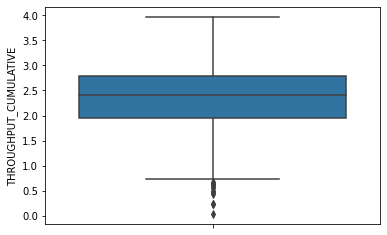

In [282]:
# propensity to make a referral: boxplot throughput
sns.boxplot(y=(data_max_clust[data_max_clust['y_prop_label']==1])['THROUGHPUT_CUMULATIVE'])



In [288]:
# propensity to make a referral: throughput summary stats
((data_max_clust[data_max_clust['y_prop_label']==1])['THROUGHPUT_CUMULATIVE']).describe()

count    531.000000
mean       2.277081
std        0.738308
min        0.030000
25%        1.960000
50%        2.410000
75%        2.790000
max        3.970000
Name: THROUGHPUT_CUMULATIVE, dtype: float64